# 第5部 状態空間モデルとカルマンフィルタ

## パッケージインポート

In [79]:
import arviz
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pystan
import seaborn as sns



## 第6部-3章 実装：Stanの使い方

In [127]:
# data
n_sample = 100
y = np.zeros(n_sample)

# parameters
mu_zero = 100               # 状態の初期値
mu = np.zeros(n_sample)     # 状態の推定値
s_w = 1000                  # 過程誤差の分散
s_v = 5000                  # 観測誤算の分散

In [135]:
# 状態の初期値から最初の時点を得る
mu[0] = np.random.normal(size=1, loc=mu_zero, scale=np.sqrt(s_w))

# 状態方程式に従い、状態が遷移する
for i, _ in enumerate(mu[1:]):
    mu[i] = np.random.normal(size=1, loc=mu[i-1], scale=np.sqrt(s_w))

# 観測方程式に従い、観測値が得られる
for i, _ in enumerate(y):
    y[i] = np.random.normal(size=1, loc=mu[i], scale=np.sqrt(s_v))

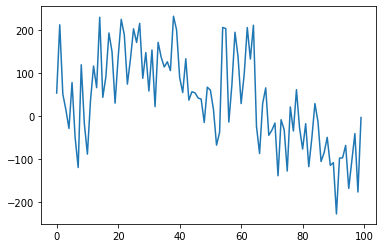

In [136]:
plt.plot(y)

In [130]:
# Stanによるローカルレベルモデルの推定
STAN_FILE = '6-3-local-level-model.stan'

with open('./stan/'+STAN_FILE, encoding='UTF-8') as f:
    stan_code = f.read()

data_sim = {
    "y": y,
    "n_sample": n_sample
}

sm = pystan.StanModel(model_code=stan_code)
fit = sm.sampling(data=data_sim, 
                    iter=5000,  # iter: 繰り返し数、乱数を生成する回数の指定
                    warmup=2500, # warmup: 生成された乱数を切り捨てる期間
                    thin=5,    # thin: 間引き数, n個に1個を間引きして捨てる
                    chains=4,  # chains: iter回の乱数生成を行う回数、
                    seed=1)

# posterior = stan.build(stan_code, data=data_sim, random_seed=1)
# fit = posterior.sample(
#                         num_samples=1000,   # iter: 繰り返し数、乱数を生成する回数の指定
#                         num_warmup=50,      # warmup: 生成された乱数を切り捨てる期間
#                         num_thin=1,         # thin: 間引き数, n個に1個を間引きして捨てる
#                         num_chains=4,       # chains: iter回の乱数生成を行う回数、
#                         )

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7a4a23af9ed43d14e032389c3bd6e594 NOW.
C:\Users\sk0ea\AppData\Local\Programs\Python\Python37\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\sk0ea\AppData\Local\Temp\tmpeeg3w4ze\stanfit4anon_model_7a4a23af9ed43d14e032389c3bd6e594_885933465583946505.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


array([[<AxesSubplot:title={'center':'mu_zero'}>,
        <AxesSubplot:title={'center':'mu_zero'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'s_w'}>,
        <AxesSubplot:title={'center':'s_w'}>],
       [<AxesSubplot:title={'center':'s_v'}>,
        <AxesSubplot:title={'center':'s_v'}>]], dtype=object)

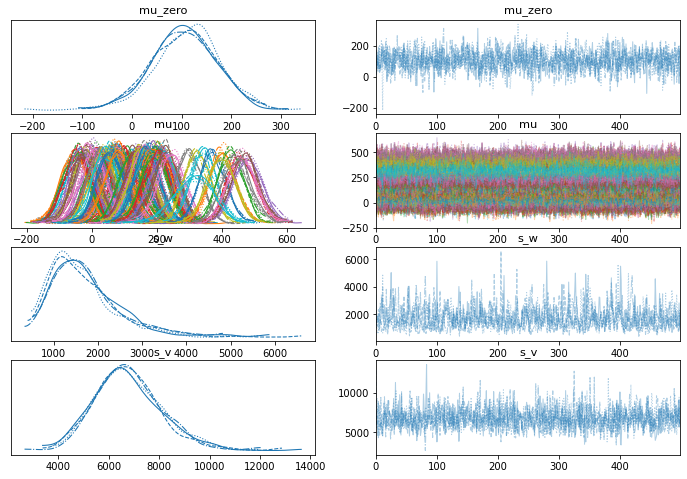

In [131]:
arviz.plot_trace(fit)

In [132]:
# 結果を出力
sampling_result = fit.extract()
len(sampling_result['s_w'])

# 95%区間と中央値
print(np.quantile(sampling_result['s_w'], [0.025, 0.5, 0.975]))

[ 665.62653325 1547.12344007 3705.325634  ]


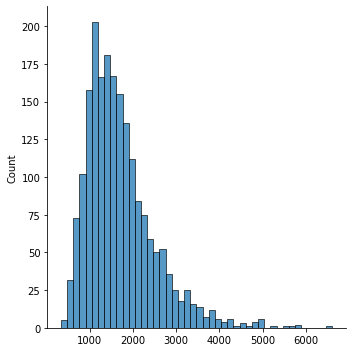

In [133]:
sns.displot(sampling_result['s_w']);

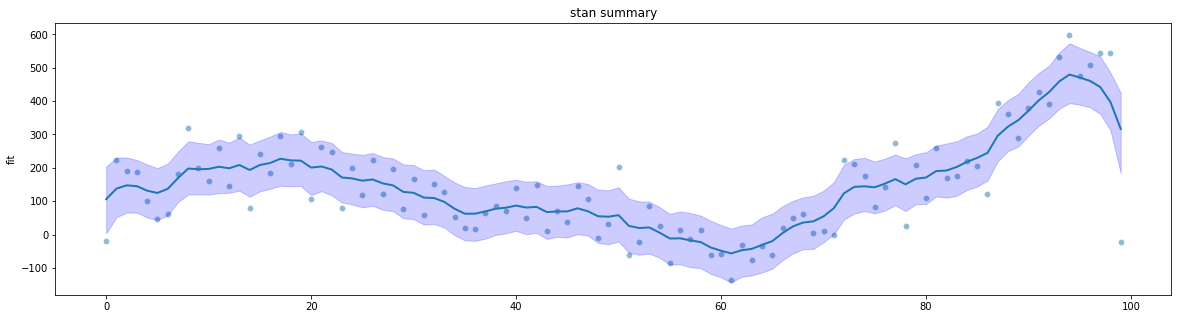

In [134]:
# 推定結果の図示
# for mu in sampling_result['mu']:

model_mu = [list(np.quantile(x, [0.025, 0.5, 0.975])) for x in sampling_result['mu'].T]
model_mu = pd.DataFrame(model_mu, columns=['lwr', 'fit', 'upr'])

model_mu
f, ax= plt.subplots(figsize=(20,5))

ax = sns.scatterplot(data=y, alpha=0.5)
ax = sns.lineplot(data=model_mu['fit'], lw=2)
ax = plt.fill_between(x=model_mu.index, y1=model_mu['lwr'], y2=model_mu['upr'], alpha=0.2, color='b')
plt.title('stan summary');

## 第6部-4章 応用：複雑な観測方程式を持つモデル

Text(0.5, 1.0, 'catch_y')

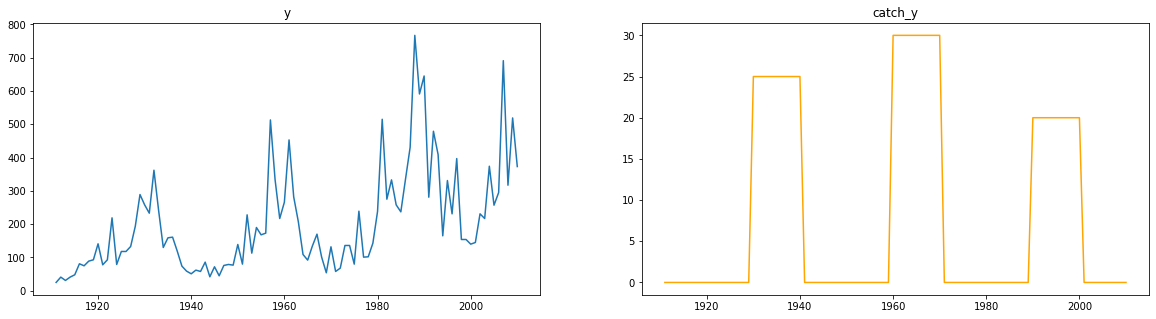

In [160]:
df = pd.read_csv('./input/6-4-animal_catch_data.csv', parse_dates=[0])
df = df.set_index('time')

f, ax= plt.subplots(1,2,figsize=(20,5))

ax[0].plot(df['y']) # 生物の個体数
ax[1].plot(df['catch_y'], color='orange') # 生物の捕獲数
ax[0].set_title("y")
ax[1].set_title("catch_y")

In [169]:
# Stanによるカウントモデルの推定
STAN_FILE = '6-4-count-model.stan'

with open('./stan/'+STAN_FILE, encoding='UTF-8') as f:
    stan_code = f.read()

data_sim = {
    "y": df['y'],
    "catch_y": df['y'],
    "n_sample": len(df)
}

sm = pystan.StanModel(model_code=stan_code)
fit = sm.sampling(data=data_sim, 
                    iter=8000,  # iter: 繰り返し数、乱数を生成する回数の指定
                    warmup=1000, # warmup: 生成された乱数を切り捨てる期間
                    thin=10,    # thin: 間引き数, n個に1個を間引きして捨てる
                    chains=4,  # chains: iter回の乱数生成を行う回数、
                    seed=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e28f33d28e50b6ddda5fe09e53df0c3b NOW.
C:\Users\sk0ea\AppData\Local\Programs\Python\Python37\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\sk0ea\AppData\Local\Temp\tmpp8qr8tre\stanfit4anon_model_e28f33d28e50b6ddda5fe09e53df0c3b_2910517940019079500.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [170]:
# 推定されたパラメタの確認
fit

Inference for Stan model: anon_model_e28f33d28e50b6ddda5fe09e53df0c3b.
4 chains, each with iter=8000; warmup=1000; thin=10; 
post-warmup draws per chain=700, total post-warmup draws=2800.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
trend               0.15  1.3e-3   0.06   0.04    0.1   0.14   0.18   0.28   2299    1.0
coef_catch_y      5.9e-4  5.5e-6 2.6e-4 1.2e-4 4.1e-4 5.7e-4 7.5e-4 1.1e-3   2228    nan
mu_zero             3.31  7.4e-3   0.39   2.55   3.05   3.31   3.57   4.07   2800    1.0
mu[0]               3.31  4.7e-3   0.25   2.83   3.14    3.3   3.48   3.79   2800    1.0
mu[1]               3.53  3.9e-3   0.21   3.13   3.39   3.52   3.67   3.95   2800    1.0
mu[2]               3.56  3.9e-3    0.2   3.17   3.42   3.56   3.69   3.94   2644    1.0
mu[3]               3.74  3.8e-3    0.2   3.34   3.61   3.74   3.87   4.11   2755    1.0
mu[4]               3.95  3.6e-3   0.19   3.57   3.82   3.95   4.07   4.32   2800    1.0
mu[5]     

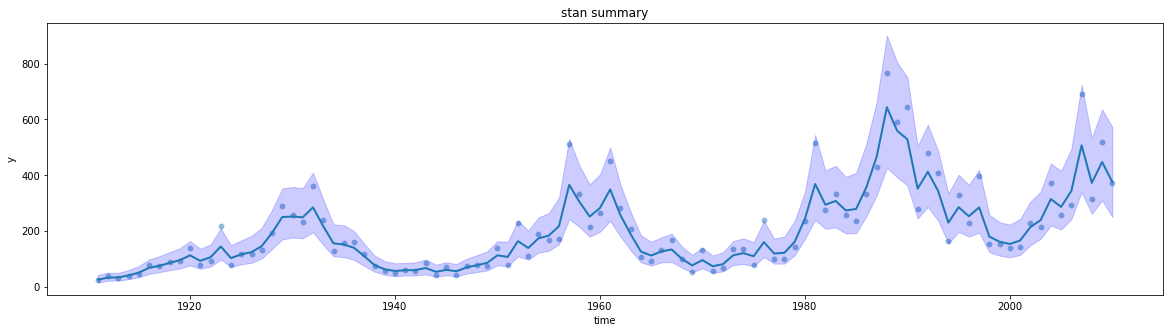

In [182]:
# 平滑化された個体数の図示
sampling_result = fit.extract()

model_lambda_smooth = [list(np.quantile(x, [0.025, 0.5, 0.975])) for x in sampling_result['lambda_smooth'].T]
model_lambda_smooth = pd.DataFrame(model_lambda_smooth, columns=['lwr', 'fit', 'upr'])
model_lambda_smooth = model_lambda_smooth.set_index(df.index)

f, ax= plt.subplots(figsize=(20,5))

ax = sns.scatterplot(data=df['y'], alpha=0.5)
ax = sns.lineplot(data=model_lambda_smooth['fit'], lw=2)
ax = plt.fill_between(x=model_lambda_smooth.index, y1=model_lambda_smooth['lwr'], y2=model_lambda_smooth['upr'], alpha=0.2, color='b')
plt.title('stan summary');

## 第6部-5章 応用：非線形な状態方程式を持つモデル

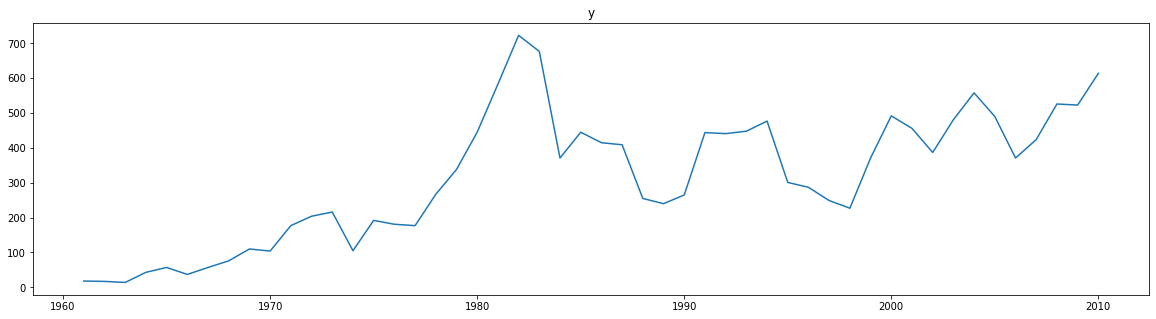

In [190]:
df = pd.read_csv('./input/6-5-logistic-growth-data.csv', parse_dates=[0])
df = df.set_index('time')

f, ax= plt.subplots(figsize=(20,5))

ax.plot(df['y']) # 生物の個体数
ax.set_title("y");

In [196]:
# Stanによるモデルの推定
STAN_FILE = '6-5-logistic-growth-model.stan'

with open('./stan/'+STAN_FILE, encoding='UTF-8') as f:
    stan_code = f.read()

data_sim = {
    "y": df['y'],
    "n_sample": len(df)
}

sm = pystan.StanModel(model_code=stan_code)
fit = sm.sampling(data=data_sim, 
                    iter=5000,  # iter: 繰り返し数、乱数を生成する回数の指定
                    # warmup=1000, # warmup: 生成された乱数を切り捨てる期間
                    thin=5,    # thin: 間引き数, n個に1個を間引きして捨てる
                    chains=4,  # chains: iter回の乱数生成を行う回数、
                    seed=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0ec275ca9e9fc327f78838a492e7a5fe NOW.
C:\Users\sk0ea\AppData\Local\Programs\Python\Python37\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\sk0ea\AppData\Local\Temp\tmpfn4mppek\stanfit4anon_model_0ec275ca9e9fc327f78838a492e7a5fe_1221958739822399880.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [197]:
# 推定されたパラメタの確認
fit

Inference for Stan model: anon_model_0ec275ca9e9fc327f78838a492e7a5fe.
4 chains, each with iter=5000; warmup=2500; thin=5; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
r                   0.17  1.4e-3   0.06   0.04   0.12   0.17   0.21   0.29   2000    1.0
K                   6.23    0.02   0.66    5.6   5.92    6.1   6.34   7.85   1906    1.0
mu_zero             2.74  7.6e-3   0.34   2.08   2.52   2.74   2.97   3.39   2000    1.0
mu[0]               2.74  4.6e-3    0.2   2.33   2.61   2.75   2.89   3.13   1961    1.0
mu[1]               2.86  3.7e-3   0.17   2.52   2.74   2.86   2.98   3.17   2000    1.0
mu[2]               3.01  3.6e-3   0.16   2.68   2.91   3.01   3.11   3.32   2000    1.0
mu[3]               3.63  2.9e-3   0.13   3.39   3.55   3.64   3.72   3.88   1954    1.0
mu[4]               3.93  2.7e-3   0.12   3.69   3.85   3.93   4.01   4.16   2000    1.0
mu[5]      

array([[<AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'r'}>],
       [<AxesSubplot:title={'center':'K'}>,
        <AxesSubplot:title={'center':'K'}>],
       [<AxesSubplot:title={'center':'mu_zero'}>,
        <AxesSubplot:title={'center':'mu_zero'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'s_w'}>,
        <AxesSubplot:title={'center':'s_w'}>],
       [<AxesSubplot:title={'center':'lambda'}>,
        <AxesSubplot:title={'center':'lambda'}>],
       [<AxesSubplot:title={'center':'mu_smooth'}>,
        <AxesSubplot:title={'center':'mu_smooth'}>],
       [<AxesSubplot:title={'center':'lambda_smooth'}>,
        <AxesSubplot:title={'center':'lambda_smooth'}>]], dtype=object)

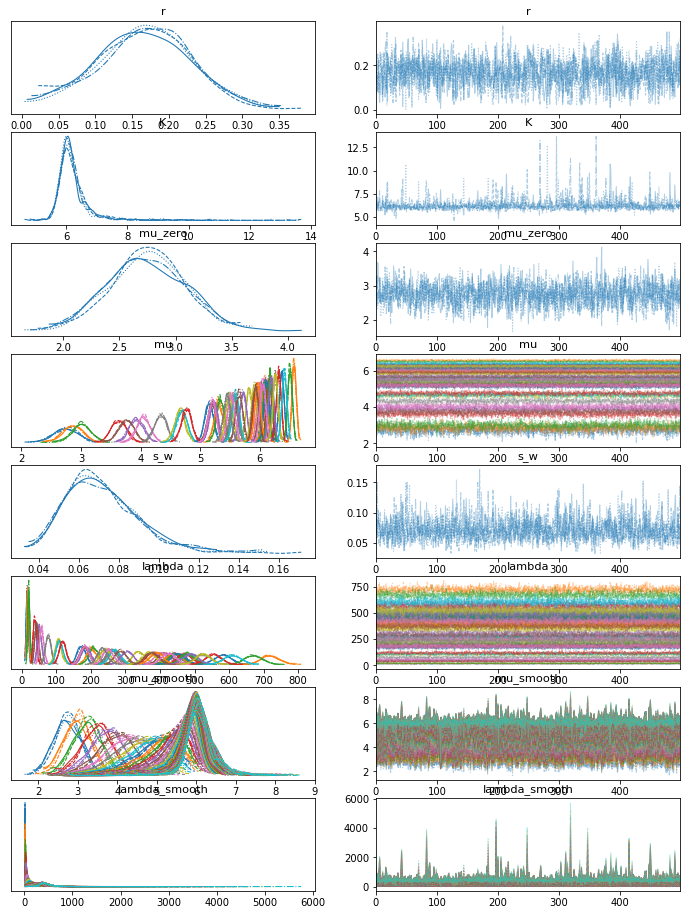

In [198]:
arviz.plot_trace(fit)

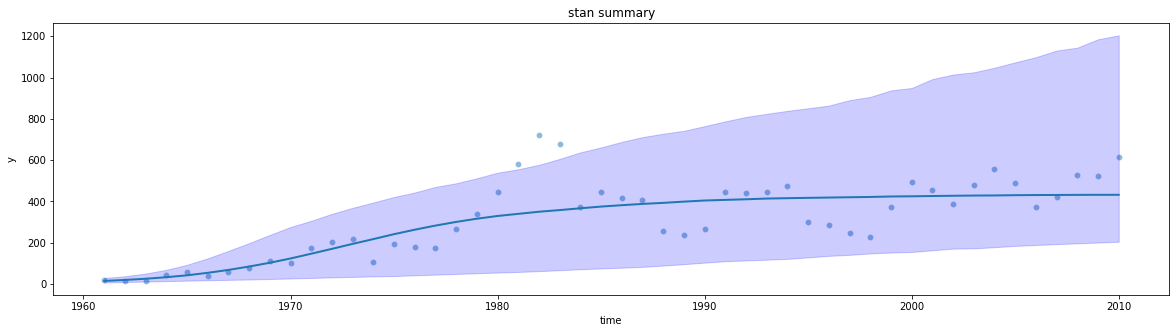

In [199]:
# 平滑化された個体数の図示
sampling_result = fit.extract()

model_lambda_smooth = [list(np.quantile(x, [0.025, 0.5, 0.975])) for x in sampling_result['lambda_smooth'].T]
model_lambda_smooth = pd.DataFrame(model_lambda_smooth, columns=['lwr', 'fit', 'upr'])
model_lambda_smooth = model_lambda_smooth.set_index(df.index)

f, ax= plt.subplots(figsize=(20,5))

ax = sns.scatterplot(data=df['y'], alpha=0.5)
ax = sns.lineplot(data=model_lambda_smooth['fit'], lw=2)
ax = plt.fill_between(x=model_lambda_smooth.index, y1=model_lambda_smooth['lwr'], y2=model_lambda_smooth['upr'], alpha=0.2, color='b')
plt.title('stan summary');